# Tutorial

## Author: Jisheng Zhang

This tutorial provides an example simulation by CMAPPER (based on the code developed by `Zhang & Rogers 2022`). CMAPPER is a 1D code to simulate thermal evolution of rocky planets, assuming an arbitrary hot initial state (fully melted Fe core and magma ocean) upon differentiation. The simulation with the default combination of parameters (values provided in `input.txt`) should output the same result as what is shown in this notebook.

The notebook also provides routines users can adopt or modify to visualize the output. These routines can also be found in the file `test.py`, in which we use some of the routines to generate plots and movies saved in the folder `image` and `movie`.

#### All units are in SI unit unless otherwise specified

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')
import numpy as np

from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.optimize import fsolve
from pynbody.analysis.interpolate import interpolate3d
from pynbody.analysis.interpolate import interpolate2d
from scipy.interpolate import CubicSpline

save_t is a list of timesteps in years at which planet thermal and structural profiles are saved in the following folder:

'/results_MplVAL_CMFVAL_timeVAL_QradVAL_VAL_VAL_VAL_TeqVAL' with VAL being values in the file `input.txt` for the variable preceding them

t_title is a list of string variables that you can use in plt.title to set the plot title.



In [2]:
save_t=[1.0]
for i in range(1,182):
    if save_t[i-1]<5000.0:
        save_t.append(save_t[i-1]+80.0)
    elif save_t[i-1]<1e8 and save_t[i-1]>=5000.0:
        save_t.append(save_t[i-1]+int(save_t[i-1]/3.0))
    elif save_t[i-1]>=1e8 and save_t[i-1]<1e9:
        save_t.append(save_t[i-1]+int(save_t[i-1]/10.0))
    else:
        save_t.append(save_t[i-1]+int(save_t[i-1]/25.0))
        
save_t_title=save_t.copy()
t_title=[]
for i in range(len(save_t)):
    if save_t[i]<100.0 and save_t[i]>1.0:
        save_t_title[i]=save_t_title[i]-1.0
    elif save_t[i]>=100.0 and save_t[i]<10000.0:
        round_value=round(save_t[i], -2)
        save_t_title[i]=round_value
    else:
        round_value=round(save_t[i], -len(str(int(save_t[i])))+2)
        save_t_title[i]=round_value

    if save_t_title[i]<1000.0:
        if save_t[i]==1.0:
            t_title.append('time: '+str(int(save_t_title[i]))+' year')
        t_title.append('time: '+str(int(save_t_title[i]))+' years')
    elif save_t_title[i]>=1000.0 and save_t_title[i]<1000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000.0)+' kyr')
    elif save_t_title[i]>=1000000.0 and save_t_title[i]<1000000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000000.0)+' Myr')
    elif save_t_title[i]>=1000000000.0 and save_t_title[i]<1000000000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000000000.0)+' Gyr')
    st=t_title[i]
    if len(t_title[i])==11:
        t_title[i]='  '+st
    elif len(t_title[i])==12:
        t_title[i]=' '+st

## Read in evolution.txt

In [26]:
load_file=np.loadtxt('input.txt')
results_foldername='results_Mpl'+str(load_file[0])+'_CMF'+str(load_file[1])+'_time'+str(load_file[2])+'_Qrad'+str(load_file[3])+'_'+str(load_file[4])+'_'+str(load_file[5])+'_'+str(load_file[6])+'_Teq'+str(load_file[8])

load_evolution=np.loadtxt(results_foldername+'/evolution.txt')
evo=load_evolution.copy()
print(results_foldername)

results_Mpl1.5_CMF0.326_time12.0_Qrad1.0_1.0_1.0_1.0_Teq2000.0


## pick values for i_x and i_y to set x- and y-axis to plot thermal history of the planet

## variable in each column in evo 
### everything is in SI units unless specified otherwise

#### 00 time 
#### 01 time stepsize 
#### 02 mass averaged mantle temperature 
#### 03 mass averaged core temperature 
#### 04 surface temperature 
#### 05 core mantle boundary temperature 
#### 06 central temperature
#### 07 surface heat flux 
#### 08 core mantle boundary heat flux 
#### 09 conductive heat flux along core adiabat 
#### 10 planet radius 
#### 11 core radius 
#### 12 central pressure 
#### 13 core mantle boundary pressure 
#### 14 inner core radius 
#### 15 inner core mass 
#### 16 thickness of dynamo source region in magma ocean 
#### 17 mantle radiogenic heating 
#### 18 core radiogenic heating 
#### 19 inner core conductive heat flow 
#### 20 core thermal buoyancy flux 
#### 21 core compositional buouyancy flux 
#### 22 core magnetic dipole moment

### What are each columns in evolution.txt
(From column 0 to column 22)

In [27]:
# read in the header of evolution.txt
f = open(results_foldername+'/evolution.txt')
header = f.readline()
f.close()
header=header.split(',')
header[0]=header[0][1:]
header[-1]=header[-1][:-2]
# example: what is column 10? 
ind=10
print('column %i is %s'%(ind,header[int(ind)][1:]))

column 10 is planet radius


### default choice of unit, label, and axis scale for each column 
usually SI unit, unless otherwise specified

In [28]:
# string variables for axis labels are saved in header

# default choice of units for each quantities
axis_unit=['Gyr', 'Myr', 'K', 'K', 'K', 'K', 'K', r'$Wm^{-2}$', r'$Wm^{-2}$', r'$Wm^{-2}$', 
             r'$R_{\oplus}$', r'$R_{\oplus}$', 'GPa', 'GPa', 'km', r'$M_{\oplus}$', 'km', 'TW', 'TW', 
             r'$Wm^{-2}$', r'$m^2s^{-3}$', r'$m^2s^{-3}$', r'$10^{21} Am^2$']
# update values in evo according to the unit choice, if not updated here, then SI unit is used.
evo[:,0]=evo[:,0]/(86400.0*365.0*1e9)
evo[:,1]=evo[:,1]/(86400.0*365.0*1e6)
evo[:,10]=evo[:,10]/6371000.0
evo[:,11]=evo[:,11]/6371000.0
evo[:,12]=evo[:,12]/1e9
evo[:,13]=evo[:,13]/1e9
evo[:,14]=evo[:,14]/1e3
evo[:,15]=evo[:,15]/5.972e24
evo[:,16]=evo[:,16]/1e3
evo[:,17]=evo[:,17]/1e12
evo[:,18]=evo[:,18]/1e12
evo[:,22]=evo[:,22]/1e21
# default axis scale for each column. Either 'linear' or 'log'.
axis_scale=['linear','log','linear','linear','log',
            'linear','linear','log','log','log',
            'linear','linear','linear','linear','linear',
            'linear','linear','log','log','log',
            'log','log','log']


(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10'),
  Text(12.0, 0, '12'),
  Text(14.0, 0, '14')])

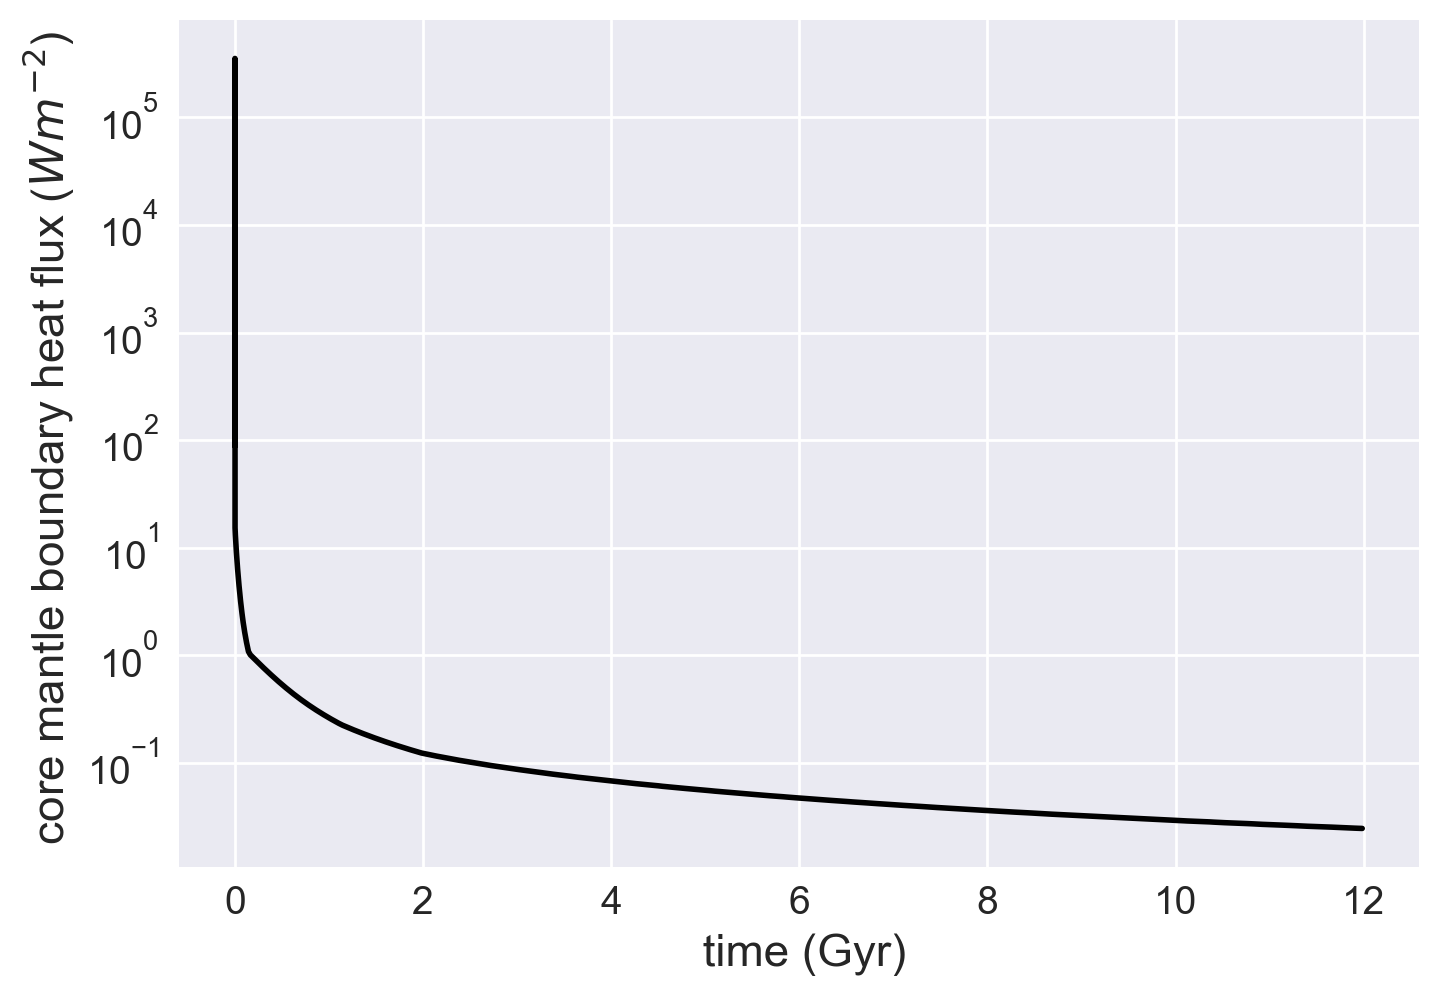

In [32]:
i_x=0
i_y=8
plt.plot(evo[:,i_x],evo[:,i_y],color='black',linewidth=2.0)
plt.ylabel(header[i_y]+' ('+axis_unit[i_y]+')',fontsize=16.5)
plt.xlabel(header[i_x]+' ('+axis_unit[i_x]+')',fontsize=16.5) 
plt.xscale(axis_scale[i_x])
plt.yscale(axis_scale[i_y])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)


In [35]:
evo_1_n=np.loadtxt('../evolution_1000_new.txt')
evo_1_o=np.loadtxt('../evolution_1000_old.txt')
evo_2_n=np.loadtxt('../evolution_2000_new.txt')
evo_2_o=np.loadtxt('../evolution_2000_old.txt')

In [24]:
evo[:,0]

array([0.00000000e+00, 1.59423600e-08, 3.20448630e-08, ...,
       1.19599859e+01, 1.19799859e+01, 1.19999859e+01])

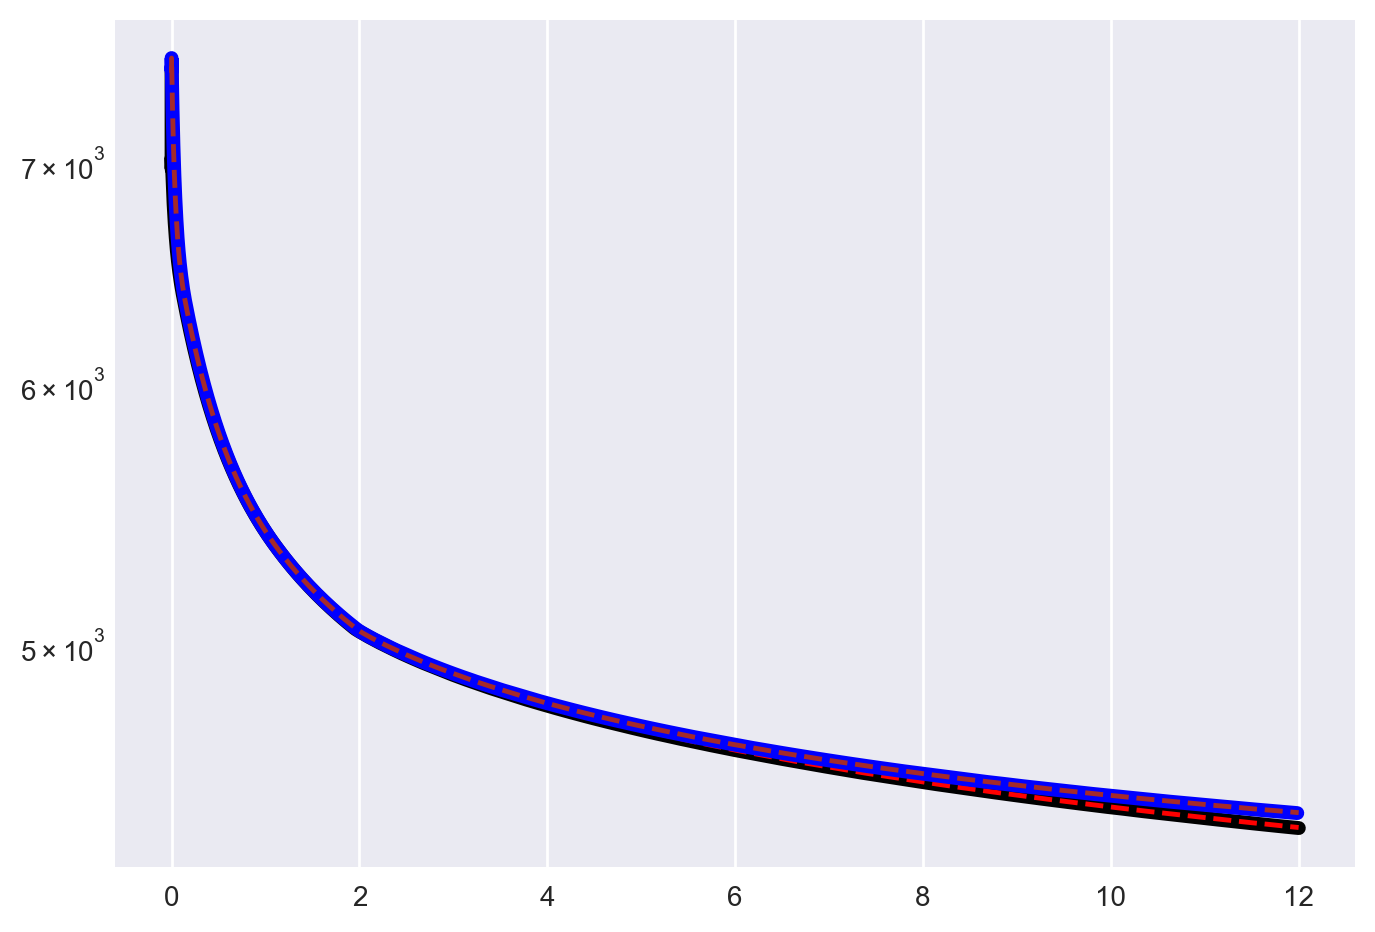

In [46]:
i_y=5
plt.plot(evo_1_n[:,i_x]/86400.0/365.0/1e9,evo_1_n[:,i_y],color='black',linewidth=5.0)

plt.yscale('log')
plt.plot(evo_1_o[:,i_x]/86400.0/365.0/1e9,evo_1_o[:,i_y],color='red',linestyle='dashed')


plt.plot(evo_2_n[:,i_x]/86400.0/365.0/1e9,evo_2_n[:,i_y],color='blue',linewidth=5.0)

plt.yscale('log')
plt.plot(evo_2_o[:,i_x]/86400.0/365.0/1e9,evo_2_o[:,i_y],color='brown',linestyle='dashed')


### A few quantities that are usually plotted together 

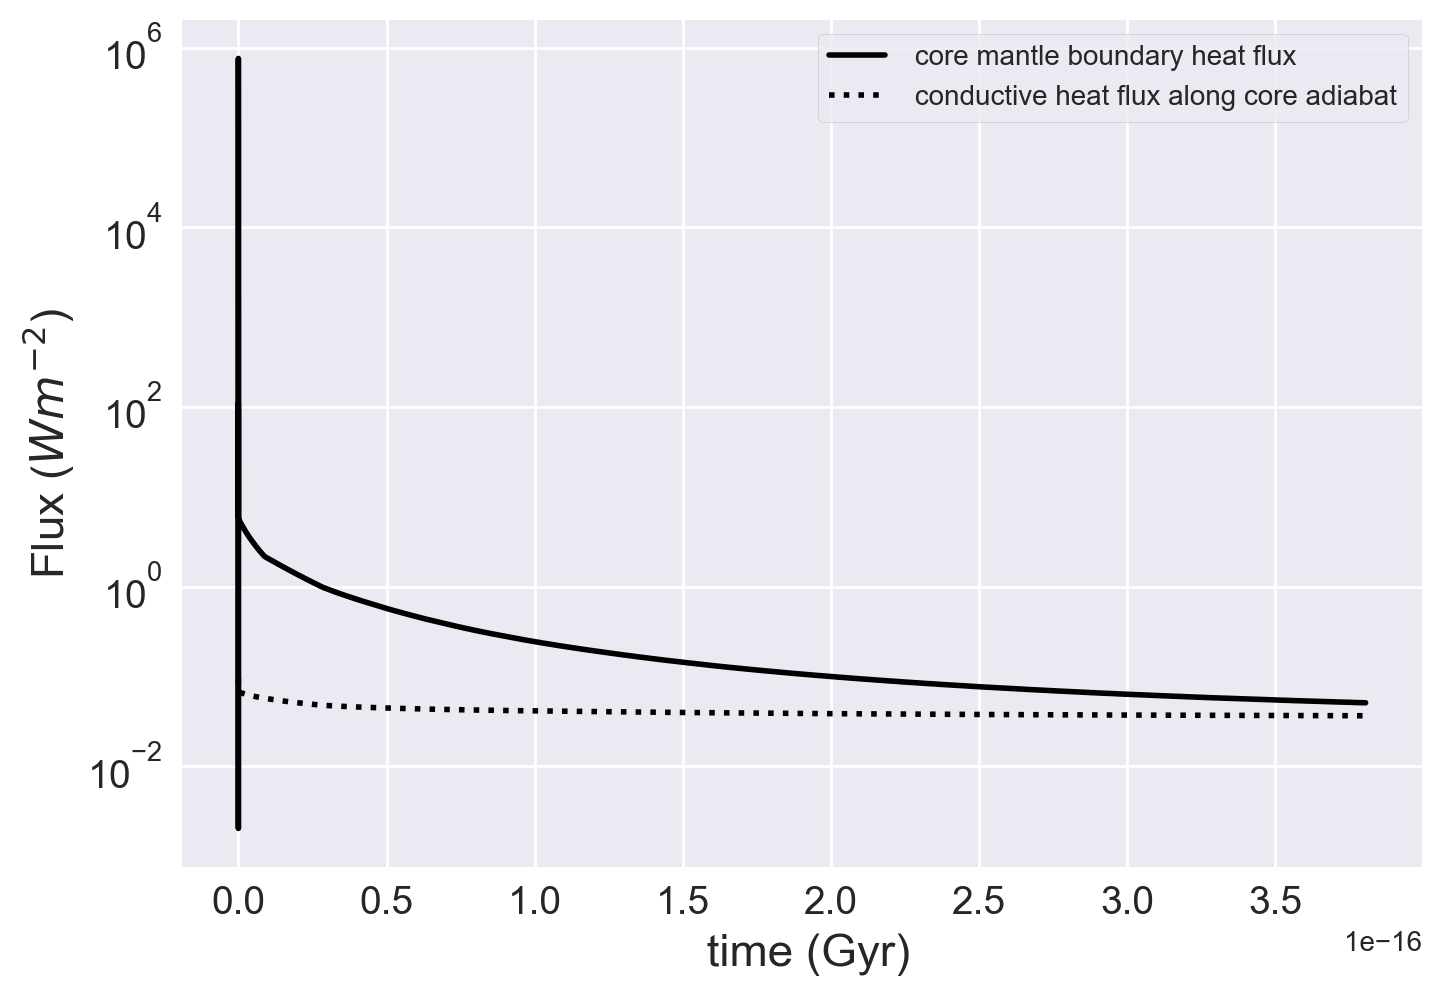

In [56]:
i_x=0
i_y=8
plt.plot(evo[:,i_x],evo[:,i_y],color='black',linewidth=2.0,label=header[i_y])
i_y=9
plt.plot(evo[:,i_x],evo[:,i_y],color='black',linestyle=':',linewidth=2.0,label=header[i_y])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xscale(axis_scale[i_x])
plt.yscale(axis_scale[i_y])
plt.ylabel('Flux'+' ('+axis_unit[i_y]+')',fontsize=16.5)
plt.xlabel(header[i_x]+' ('+axis_unit[i_x]+')',fontsize=16.5) 
plt.legend(frameon=True)

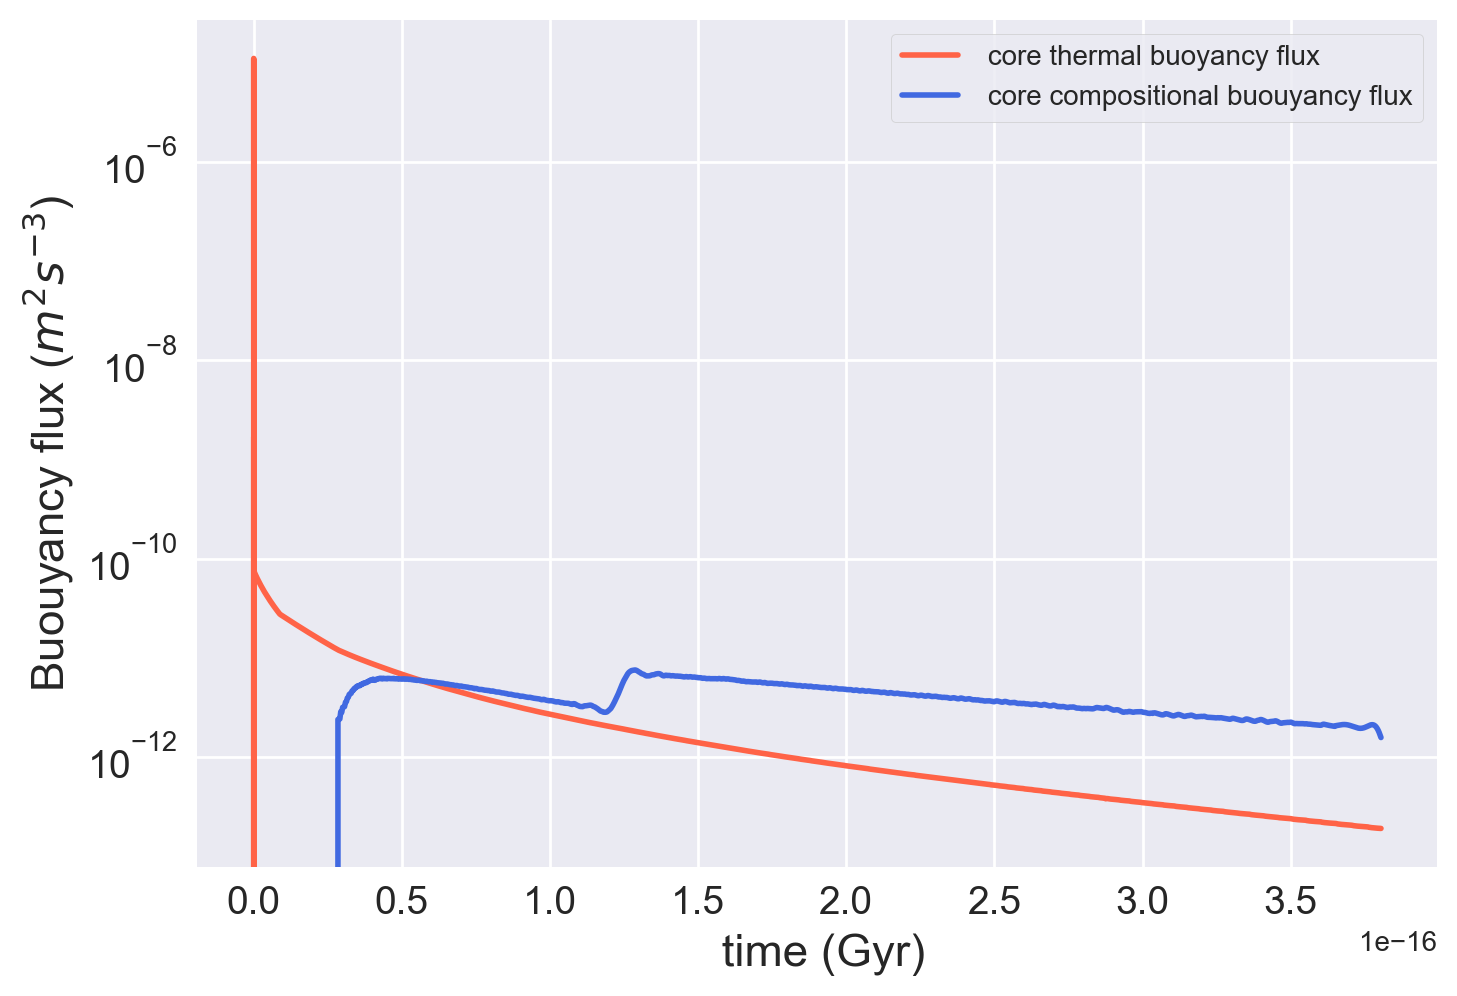

In [58]:
i_x=0
i_y=20
plt.plot(evo[:,i_x],evo[:,i_y],color='tomato',linewidth=2.0,label=header[i_y])
i_y=21
plt.plot(evo[:,i_x],evo[:,i_y],color='royalblue',linewidth=2.0,label=header[i_y])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xscale(axis_scale[i_x])
plt.yscale(axis_scale[i_y])
plt.ylabel('Buouyancy flux'+' ('+axis_unit[i_y]+')',fontsize=16.5)
plt.xlabel(header[i_x]+' ('+axis_unit[i_x]+')',fontsize=16.5) 
plt.legend(frameon=True)

## plotting profiles saved at 182 pre-selected timesteps.

### Quantities in each column 
#### 'radius (m)' 
#### 'pressure (Pa)' 
#### 'density (km/m^3)' 
#### 'gravitational acceleration (m/s^2)' 
#### 'temperature (K)' 
#### 'thermal expansion coefficient (K^{-1})' 
#### 'specific heat (J/K/kg)'        
#### 'convective heat flux (W/m^2)' 
#### 'conductivt heat flux (W/m^2)' 
#### 'total heat flux (W/m^2)'         
#### 'convective velocity (m/s)' 
#### 'mantle magnetic Reynolds number' 
#### 'mantle viscosity (Pa s)'          
#### 'mass (kg)' 
#### 'mantle melt fraction'

In [91]:
label_list=['radius (R_Earth)', 'pressure (GPa)', 'density (km/m^3)', 'gravitational acceleration (m/s^2)', 
           'temperature (K)', 'thermal expansion coefficient (K^{-1})', 'specific heat (J/K/kg)', 
           'convective heat flux (W/m^2)', 'conductivt heat flux (W/m^2)', 'total heat flux (W/m^2)', 
           'convective velocity (m/s)', 'mantle magnetic Reynolds number', 'mantle viscosity (Pa s)', 
           'mass (M_Earth)', 'mantle melt fraction']
# default axis scale for each variable 
axis_scale_list=['linear','linear','linear','linear','linear',
                'log','linear','log','log','log',
                'log','log','log','linear','linear']

In [92]:
ind=30# select a timestep 
print('Timestep to be plotted: %2.f years'%(save_t[ind]))

# load the file
s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[ind]))+'.txt')

# update the values in the read in file, if not in SI units. 
s[:,0]=s[:,0]/6371000.0
s[:,1]=s[:,1]/1e9
s[:,13]=s[:,13]/5.972e24

Timestep to be plotted: 2401 years


x-axis is mass (M_Earth) and y-axis is convective heat flux (W/m^2)


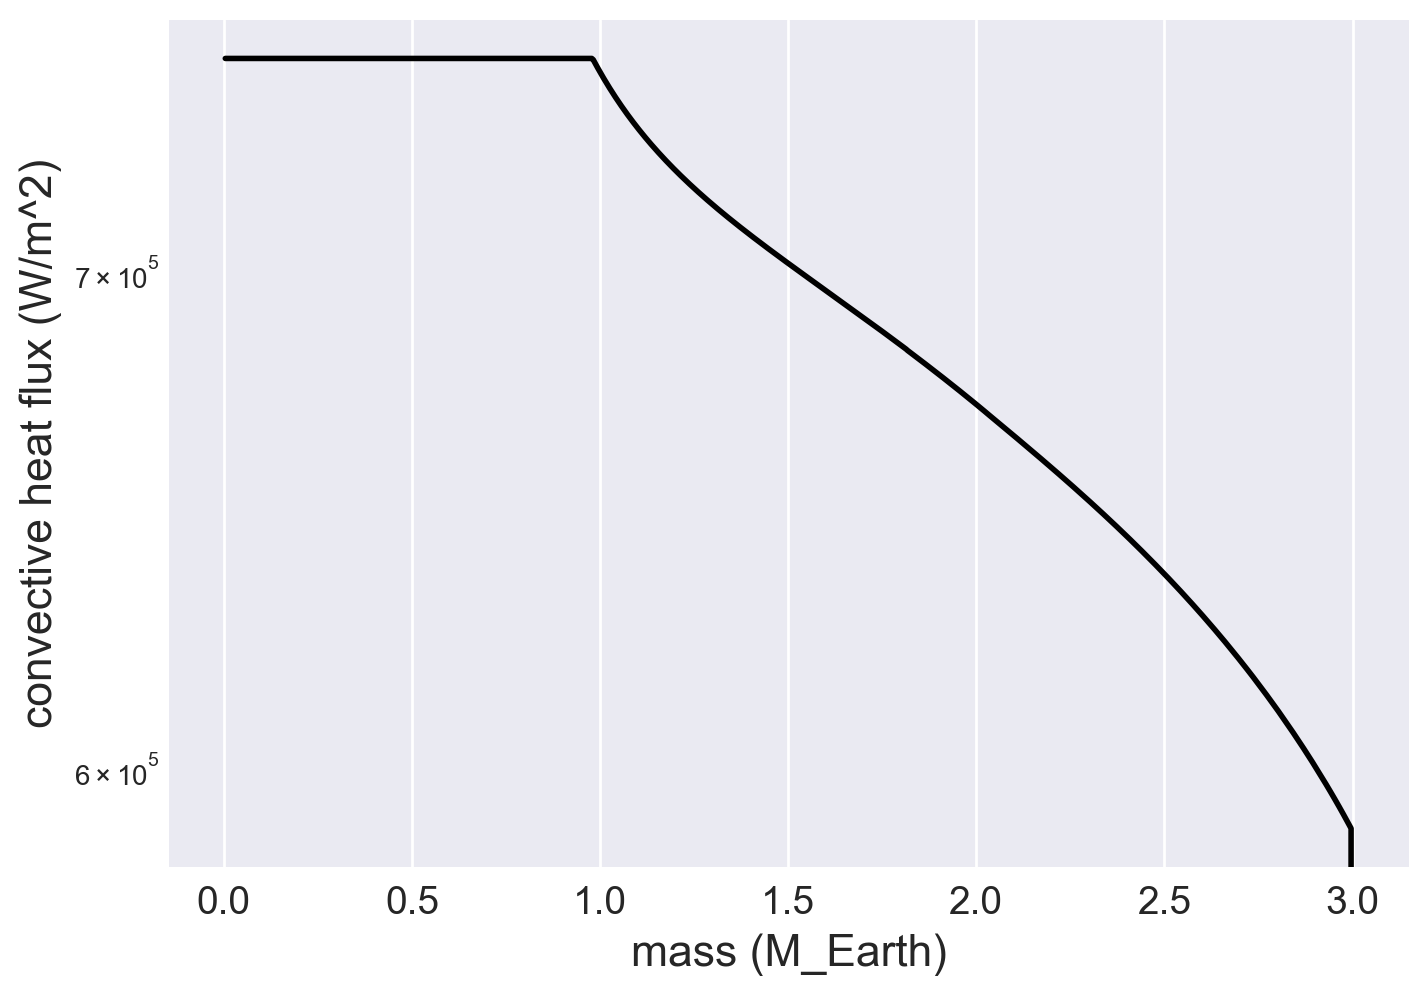

In [94]:
# pick i_x and i_y to set x and y-axis
i_x=13
i_y=7

print('x-axis is %s and y-axis is %s'%(label_list[i_x],label_list[i_y]))

# plotting
plt.yscale(axis_scale_list[i_y])
plt.xscale(axis_scale_list[i_x])
plt.xlabel(label_list[i_x],fontsize=16)
plt.ylabel(label_list[i_y],fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.plot(s[:,i_x],s[:,i_y],color='black',linewidth=2.0)

In [ ]:
# a function to set the minimum value and maximum value of x or y axis. 

# axis_scale is a string that sets the scale of the axis. 
# it takes two values: axis_scale = 'log' or axis_scale = 'linear'
def f_axis_max_min(v_min,v_max,axis_scale):
    if axis_scale=='log':
        v_max=np.log10(v_max)
        v_min=np.log10(v_min)
        dv=np.abs(v_max-v_min)/10.0
        v_max=10.0**(v_max+dv)
        v_min=10.0**(v_min-dv)
    else:
        dv=np.abs(v_max-v_min)/10.0
        v_max=v_max+dv
        v_min=v_min-dv
    return v_min,v_max

# how to format the axis? you can use the following lines of code
# for x axis
# plt.xlim(v_min,v_max)